<a href="https://colab.research.google.com/github/karencheung369/Kafka/blob/main/ApacheKafkaSetupGuide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Apache Kafka</b></h1></center>
<p><b>
Not only is Apache Kafka is a distributed streaming platform, but it is also a messaging system, as well as a storage system
<br><br>
A streaming platform with three key capabilities:<br>
*  Publish and subscribe to streams of records like a message queue or enterprise messaging system.<br>
*  Store streams of records in a fault-tolerant durable way.<br>
*    Process streams of records as they occur.<br>
<br>
Generally used for two broad classes of applications: <br>
*   Building reliable real-time streaming data pipelines to get data between systems or applications.<br>
*   Building real-time streaming applications that transform or react to the streams of data.
</b></p>
<br>
<center><h1><b>Kafka Architecture</b><h1></center>
<p><b>
1. Kafka stores key-value messages or records that come from Producers which are processes. <br>
2. data can be partitioned into different partitions within different "topics". <br>
3. Within a partition, messages are ordered by their offsets  (position of a message within a partition); indexed and stored with a timestamp. <br>
4. Consumers are processes that read messages from partitions.
</b>

<b>Producer(s)</b> writes messages into <b>topic(s).</b><br>
<b>Topic</b> has 1 or multiple <b>partitions.</b><br>
<b>Messages</b> in a <b>topic</b> across <b>partitions</b> are not guaranteed their order.<br>
<b>Offset</b> is the position of a message within a partition.<br>
<b>Partition</b> is like a Message Queue; messages are ordered.<br>
<b>Cnsumer(s)</b> can subscribe to <b>topic(s)</b> and read message, a <b>topic can also be subscribed by multiple consumers.


Kafka runs on a cluster of one or more servers (called brokers), and the partitions of all topics are distributed across the cluster nodes (i.e. brokers). Additionally, partitions are replicated to multiple brokers. This architecture allows Kafka to deliver massive streams of messages in a fault-tolerant fashion

<center><h1><b>Build Kafka cluster</b></h1></center>
<p>
My environment has Hadoop and Spark running on the 11 slave nodes. I will build Kafka cluster on 8 nodes (broker 0 to 7).<br>
</p>

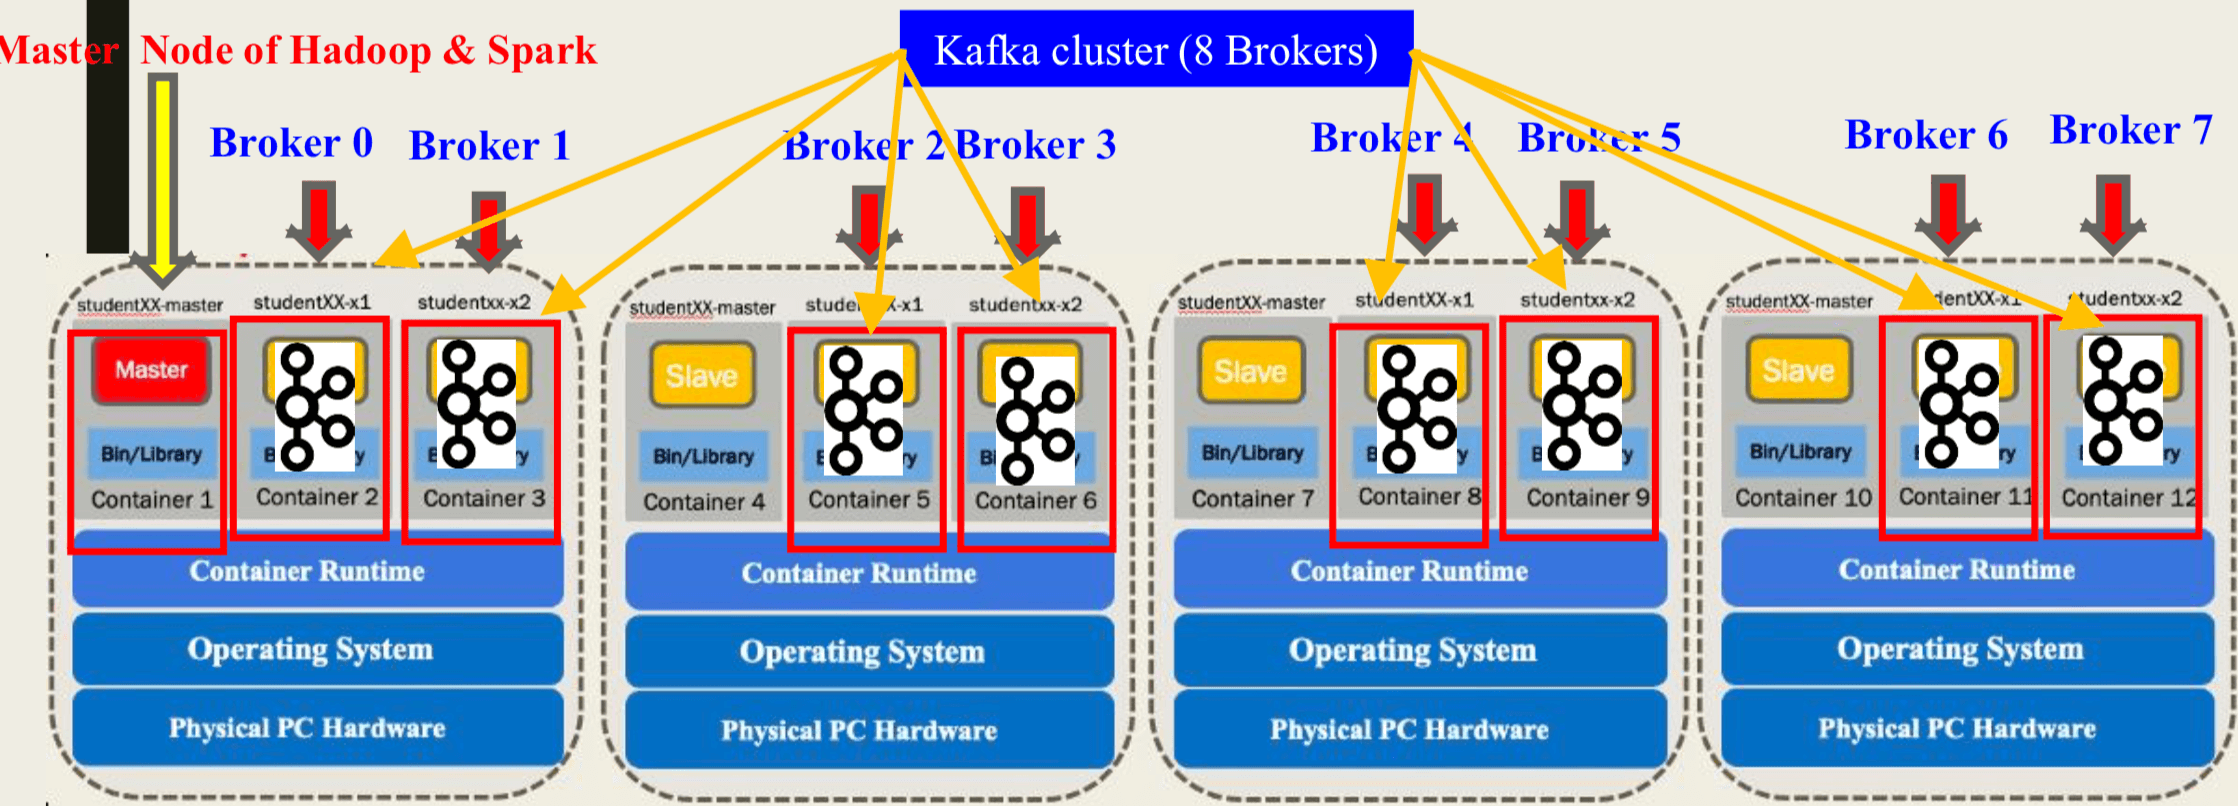

<p>Kafka cluster and the Hadoop & Spark cluster are logically separate and independent, but since Kafka cluster physically overlaps with the Hadoop & Spark cluster on those 8 container nodes which have 7G memory, so they may compete for the hardware resources.</p>

<center><h1><b>Download Kafka</b></h1></center>
<p>Install Kafka on one node (broker 0) first, then later copy it to other 7 nodes.</p>

```
cd /opt
sudo wget https://archive.apache.org/dist/kafka/2.4.0/kafka_2.11-2.4.0.tgz
```
<center><h1><b>Configure Kafka Profile</b></h1></center>
<p>Add the paths to /etc/profile</p>


```
 sudo vim /etc/profile
 export KAFKA_HOME=/opt/kafka_2.11-2.4.0
 export CLASSPATH=$CLASSPATH:$KAFKA_HOME/libs
 export PATH=$PATH:$KAFKA_HOME/bin
```
Source the profile, also do this whenever you see “bash: xxx: command not found”.

```
source /etc/profile
```
Create the log directory and the data directory of zookeeper.


```
cd /opt/kafka_2.11-2.4.0 mkdir zookeeper
mkdir log
mkdir log/zookeeper mkdir log/kafka
```
Create the log directory and the data directory of zookeeper
```
cd /opt/kafka_2.11-2.4.0 mkdir zookeeper
mkdir log
mkdir log/zookeeper mkdir log/kafka
```


<center><h1><b>Configure zookeeper</b></h1></center>

Configure the Zookeeper environment by editing zookeeper.properties.<br>
Role of ZooKepper in Kafka:<br>
*   Store nodes and topic registries
*   Check if the Kafka Broker is alive
*   Node failure: elect the new leader
*   ZooKeeper runs as a JVM
```
cd /opt/kafka_2.11-2.4.0
vim config/zookeeper.properties
```
Change the “dataDir” and “dataLogDir”.<br>
dataDir is the location where ZooKeeper will store the in-memory database snapshots.<br>
dataLogDir option will direct the machine to write the transaction log to the dataLogDir rather than the dataDir.

```
dataDir=/opt/kafka_2.11-2.4.0/zookeeper
dataLogDir=/opt/kafka_2.11-2.4.0/log/zookeeper
```
Add the following lines in zookeeper.properties.<br>
A tickTime of 2000 milliseconds is the suggested interval between heartbeats.

```
 #About connection
 tickTime=2000
 initLimit=10
 syncLimit=5
```
Configure the Zookeeper by editing zookeeper.properties.<br>
Add all the 8 nodes in zookeeper.properties.<br>
Make sure each broker has a unique broker.id (0, 1, 2, ... 7)
```
 server.0=hostnamesX-x1:2888:3888
 server.1=hostnamesX-x2:2888:3888
 server.2=hostnamesY-x1:2888:3888
 server.3=hostnamesY-x2:2888:3888
 server.4=hostnamesZ-x1:2888:3888
 server.5=hostnamesZ-x2:2888:3888
 server.6=hostnamesK-x1:2888:3888
 server.7=hostnamesK-x2:2888:3888
```
Change the “maxClientCnxns” to 60<br>
Maximum number of client connections for a ZooKeeper server is Default: 60.<br>If set this to 0, it is unlimited.
```
maxClientCnxns=60
```
Each node running Zookeeper contains ID in myid file stored in the dataDir folder.<br>
Assign a unique ID for each Broker at each node to be managed by ZooKeeper:<br>
*   Create the “myid” file in the “dataDir” directory “/opt/kafka_2.11-2.4.0/zookeeper”
```
 cd /opt/kafka_2.11-2.4.0/zookeeper
 echo 0 > myid
```
*   View the content stored in myid file using cat command.
```
 cat myid
```
Each node in the ZooKeeper cluster has to be assigned with a unique integer identifier used by zookeeper to
recognize different nodes which run Zookeeper services.



<center><h1><b>Configure Kafka Server</b></h1></center>
<p>
Configure the Kafka server environment by editing server.properties.</p>

```
cd /opt/kafka_2.11-2.4.0
vim config/server.properties
```
broker.id should be different on different nodes. For simplicity can set broker.id to be same as that in “myid” file of current node.

```
broker.id=0
```
Delete the “#” next to listeners and add the hostname of current node.

```
listeners=PLAINTEXT://hostnameX-x1:9092
```
Set the log.dirs.
```
log.dirs=/opt/kafka_2.11-2.4.0/log/kafka
```
Set the default number of partitions of a topic.<br>
num.partitions sets the default number of partitions of a topic.
```
num.partitions=3
```
Change the zookeeper.connect.
```
 zookeeper.connect=studentX-x1:2181,studentX-x2:2181,studentY-
x1:2181,studentY-x2:2181,studentZ-x1:2181,studentZ- x2:2181,studentK-x1:2181,studentK-x2:2181
```
Then Change “zookeeper.connection.timeout.ms” from 6000 to 6000000.
```
 zookeeper.connection.timeout.ms=6000000
```
Add the following line in server.properties.
```
delete.topic.enable=true
```
Now copy Kafka and its configuration files set above on the first node to the rest of the other 7 nodes.


  


To be Continued...